# Transfer learning

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

from tqdm import tqdm

In [2]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)

In [3]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

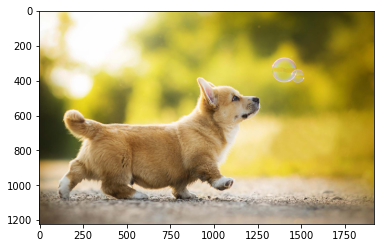

In [5]:
img_path = './data_test/con_cho.jpg'

img = Image.open(img_path)

plt.imshow(img)
plt.show()

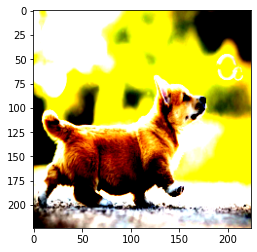

In [6]:
resize = 224
mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)

img_transform = transform(img, phase = 'train')

img_transform = img_transform.numpy().transpose(1,2,0)
img_transform = np.clip(img_transform, 0, 1)

plt.imshow(img_transform)
plt.show()


In [7]:
def make_path_list(phase = 'train'):
    root_path = './data_test/hymenoptera_data/'
    target_path = osp.join(root_path + phase + '/**/*.jpg' )
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [8]:
train_list = make_path_list(phase = 'train')
val_list = make_path_list(phase = 'val')
print(len(train_list))

243


In [9]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[35:39]
        elif self.phase == "val":
            label = img_path[33:37]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

In [10]:
train_dataset = MyDataset(train_list, transform=ImageTransform(resize, mean, std), phase="train")
val_dataset = MyDataset(val_list, transform=ImageTransform(resize, mean, std), phase="val")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


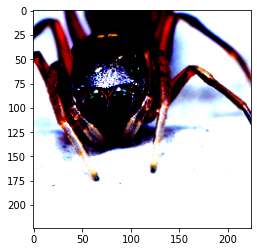

0


In [11]:
img , label = train_dataset.__getitem__(0)
print(img.shape)
plt.imshow(img.numpy().transpose(1,2,0))
plt.show()
print(label)

# Create dataloader

In [12]:
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {"train":train_dataloader, "val":val_dataloader}

In [13]:
batch_iterator = iter(dataloader_dict["train"])

inputs, labels = next(batch_iterator)

In [14]:
print(inputs.size())
print(labels)

torch.Size([4, 3, 224, 224])
tensor([0, 1, 1, 1])


# build Net

In [15]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print(net)

net = net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
params_to_update = []

update_params_name = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[ 0.0055, -0.0117, -0.0143,  ...,  0.0074, -0.0021, -0.0129],
        [ 0.0055,  0.0035, -0.0096,  ..., -0.0108,  0.0147,  0.0107]],
       requires_grad=True), Parameter containing:
tensor([-0.0108, -0.0114], requires_grad=True)]


In [17]:
# setting loss
criterior = nn.CrossEntropyLoss()
# setting optimizer
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [18]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))

        # move network to device(GPU/CPU)
        net.to(device)

        torch.backends.cudnn.benchmark = True

        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                # move inputs, labels to GPU/GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # set gradient of optimizer to be zero
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
                    
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                    
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))

In [19]:
number_epochs = 3
train_model(net, dataloader_dict, criterior, optimizer, number_epochs)

device:  cuda:0
Epoch 0/3


  2%|▏         | 1/61 [00:00<00:09,  6.29it/s]

val Loss: 0.7238 Acc: 0.4902
Epoch 1/3


  3%|▎         | 1/39 [00:00<00:04,  7.73it/s]

train Loss: 0.2728 Acc: 0.8848


  2%|▏         | 1/61 [00:00<00:06,  8.92it/s]

val Loss: 0.1739 Acc: 0.9477
Epoch 2/3


  3%|▎         | 1/39 [00:00<00:04,  8.96it/s]

train Loss: 0.1608 Acc: 0.9506


100%|██████████| 39/39 [00:04<00:00,  9.69it/s]

val Loss: 0.1303 Acc: 0.9477
